# Process
1. 소설 생성 - Text Generation
2. 해당 단락의 중요한 부분 추출 - Text Summarization  
3. 추출한 단락 그림 생성 - __Text to Image__  
4. 생성한 그림 스타일 변경 - Style Transfer

# StackGAN
* ref: https://github.com/hanzhanggit/StackGAN-v2

## 1. datasets.py

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pwd
%cd drive/MyDrive/ 

/content/drive/MyDrive


In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals


import torch.utils.data as data
import torchvision.transforms as transforms
from PIL import Image
import PIL
import os
import os.path
import pickle
import random
import numpy as np
import pandas as pd
from miscc.config import cfg

import torch.utils.data as data
from PIL import Image
import os
import os.path
import six
import string
import sys
import torch
if sys.version_info[0] == 2:
    import cPickle as pickle
else:
    import pickle

IMG_EXTENSIONS = ['.jpg', '.JPG', '.jpeg', '.JPEG',
                  '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP']


def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)


def get_imgs(img_path, imsize, bbox=None,
             transform=None, normalize=None):
    img = Image.open(img_path).convert('RGB')
    width, height = img.size
    if bbox is not None:
        r = int(np.maximum(bbox[2], bbox[3]) * 0.75)
        center_x = int((2 * bbox[0] + bbox[2]) / 2)
        center_y = int((2 * bbox[1] + bbox[3]) / 2)
        y1 = np.maximum(0, center_y - r)
        y2 = np.minimum(height, center_y + r)
        x1 = np.maximum(0, center_x - r)
        x2 = np.minimum(width, center_x + r)
        img = img.crop([x1, y1, x2, y2])

    if transform is not None:
        img = transform(img)

    ret = []
    for i in range(cfg.TREE.BRANCH_NUM):
        if i < (cfg.TREE.BRANCH_NUM - 1):
            re_img = transforms.Scale(imsize[i])(img)
        else:
            re_img = img
        ret.append(normalize(re_img))

    return ret


class ImageFolder(data.Dataset):
    def __init__(self, root, split_dir='train', custom_classes=None,
                 base_size=64, transform=None, target_transform=None):
        root = os.path.join(root, split_dir)
        classes, class_to_idx = self.find_classes(root, custom_classes)
        imgs = self.make_dataset(classes, class_to_idx)
        if len(imgs) == 0:
            raise(RuntimeError("Found 0 images in subfolders of: " + root + "\n"
                               "Supported image extensions are: " + ",".join(IMG_EXTENSIONS)))

        self.root = root
        self.imgs = imgs
        self.classes = classes
        self.num_classes = len(classes)
        self.class_to_idx = class_to_idx

        self.transform = transform
        self.target_transform = target_transform
        self.norm = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

        self.imsize = []
        for i in range(cfg.TREE.BRANCH_NUM):
            self.imsize.append(base_size)
            base_size = base_size * 2
        print('num_classes', self.num_classes)

    def find_classes(self, dir, custom_classes):
        classes = []

        for d in os.listdir(dir):
            if os.path.isdir:
                if custom_classes is None or d in custom_classes:
                    classes.append(os.path.join(dir, d))
        print('Valid classes: ', len(classes), classes)

        classes.sort()
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        return classes, class_to_idx

    def make_dataset(self, classes, class_to_idx):
        images = []
        for d in classes:
            for root, _, fnames in sorted(os.walk(d)):
                for fname in fnames:
                    if is_image_file(fname):
                        path = os.path.join(root, fname)
                        item = (path, class_to_idx[d])
                        images.append(item)
        print('The number of images: ', len(images))
        return images

    def __getitem__(self, index):
        path, target = self.imgs[index]
        imgs_list = get_imgs(path, self.imsize,
                             transform=self.transform,
                             normalize=self.norm)

        return imgs_list

    def __len__(self):
        return len(self.imgs)


class LSUNClass(data.Dataset):
    def __init__(self, db_path, base_size=64,
                 transform=None, target_transform=None):
        import lmdb
        self.db_path = db_path
        self.env = lmdb.open(db_path, max_readers=1, readonly=True, lock=False,
                             readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.length = txn.stat()['entries']
            print('length: ', self.length)
        cache_file = db_path + '/cache'
        if os.path.isfile(cache_file):
            self.keys = pickle.load(open(cache_file, "rb"))
            print('Load:', cache_file, 'keys: ', len(self.keys))
        else:
            with self.env.begin(write=False) as txn:
                self.keys = [key for key, _ in txn.cursor()]
            pickle.dump(self.keys, open(cache_file, "wb"))

        self.imsize = []
        for i in range(cfg.TREE.BRANCH_NUM):
            self.imsize.append(base_size)
            base_size = base_size * 2

        self.transform = transform
        self.target_transform = target_transform
        self.norm = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    def __getitem__(self, index):
        env = self.env
        with env.begin(write=False) as txn:
            imgbuf = txn.get(self.keys[index])

        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)
        imgs = get_imgs(buf, self.imsize,
                        transform=self.transform,
                        normalize=self.norm)
        return imgs

    def __len__(self):
        return self.length

    def __repr__(self):
        return self.__class__.__name__ + ' (' + self.db_path + ')'


class TextDataset(data.Dataset):
    def __init__(self, data_dir, split='train', embedding_type='cnn-rnn',
                 base_size=64, transform=None, target_transform=None):
        self.transform = transform
        self.norm = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        self.target_transform = target_transform

        self.imsize = []
        for i in range(cfg.TREE.BRANCH_NUM):
            self.imsize.append(base_size)
            base_size = base_size * 2

        self.data = []
        self.data_dir = data_dir
        if data_dir.find('birds') != -1:
            self.bbox = self.load_bbox()
        else:
            self.bbox = None
        split_dir = os.path.join(data_dir, split)

        self.filenames = self.load_filenames(split_dir)
        self.embeddings = self.load_embedding(split_dir, embedding_type)
        self.class_id = self.load_class_id(split_dir, len(self.filenames))
        self.captions = self.load_all_captions()

        if cfg.TRAIN.FLAG:
            self.iterator = self.prepair_training_pairs
        else:
            self.iterator = self.prepair_test_pairs

    def load_bbox(self):
        data_dir = self.data_dir
        bbox_path = os.path.join(data_dir, 'CUB_200_2011/bounding_boxes.txt')
        df_bounding_boxes = pd.read_csv(bbox_path,
                                        delim_whitespace=True,
                                        header=None).astype(int)
        #
        filepath = os.path.join(data_dir, 'CUB_200_2011/images.txt')
        df_filenames = \
            pd.read_csv(filepath, delim_whitespace=True, header=None)
        filenames = df_filenames[1].tolist()
        print('Total filenames: ', len(filenames), filenames[0])
        #
        filename_bbox = {img_file[:-4]: [] for img_file in filenames}
        numImgs = len(filenames)
        for i in xrange(0, numImgs):
            # bbox = [x-left, y-top, width, height]
            bbox = df_bounding_boxes.iloc[i][1:].tolist()

            key = filenames[i][:-4]
            filename_bbox[key] = bbox
        #
        return filename_bbox

    def load_all_captions(self):
        def load_captions(caption_name):  # self,
            cap_path = caption_name
            with open(cap_path, "r") as f:
                captions = f.read().decode('utf8').split('\n')
            captions = [cap.replace("\ufffd\ufffd", " ")
                        for cap in captions if len(cap) > 0]
            return captions

        caption_dict = {}
        for key in self.filenames:
            caption_name = '%s/text/%s.txt' % (self.data_dir, key)
            captions = load_captions(caption_name)
            caption_dict[key] = captions
        return caption_dict

    def load_embedding(self, data_dir, embedding_type):
        if embedding_type == 'cnn-rnn':
            embedding_filename = '/char-CNN-RNN-embeddings.pickle'
        elif embedding_type == 'cnn-gru':
            embedding_filename = '/char-CNN-GRU-embeddings.pickle'
        elif embedding_type == 'skip-thought':
            embedding_filename = '/skip-thought-embeddings.pickle'

        with open(data_dir + embedding_filename, 'rb') as f:
            embeddings = pickle.load(f)
            embeddings = np.array(embeddings)
            # embedding_shape = [embeddings.shape[-1]]
            print('embeddings: ', embeddings.shape)
        return embeddings

    def load_class_id(self, data_dir, total_num):
        if os.path.isfile(data_dir + '/class_info.pickle'):
            with open(data_dir + '/class_info.pickle', 'rb') as f:
                class_id = pickle.load(f)
        else:
            class_id = np.arange(total_num)
        return class_id

    def load_filenames(self, data_dir):
        filepath = os.path.join(data_dir, 'filenames.pickle')
        with open(filepath, 'rb') as f:
            filenames = pickle.load(f)
        print('Load filenames from: %s (%d)' % (filepath, len(filenames)))
        return filenames

    def prepair_training_pairs(self, index):
        key = self.filenames[index]
        if self.bbox is not None:
            bbox = self.bbox[key]
            data_dir = '%s/CUB_200_2011' % self.data_dir
        else:
            bbox = None
            data_dir = self.data_dir
        # captions = self.captions[key]
        embeddings = self.embeddings[index, :, :]
        img_name = '%s/images/%s.jpg' % (data_dir, key)
        imgs = get_imgs(img_name, self.imsize,
                        bbox, self.transform, normalize=self.norm)

        wrong_ix = random.randint(0, len(self.filenames) - 1)
        if(self.class_id[index] == self.class_id[wrong_ix]):
            wrong_ix = random.randint(0, len(self.filenames) - 1)
        wrong_key = self.filenames[wrong_ix]
        if self.bbox is not None:
            wrong_bbox = self.bbox[wrong_key]
        else:
            wrong_bbox = None
        wrong_img_name = '%s/images/%s.jpg' % \
            (data_dir, wrong_key)
        wrong_imgs = get_imgs(wrong_img_name, self.imsize,
                              wrong_bbox, self.transform, normalize=self.norm)

        embedding_ix = random.randint(0, embeddings.shape[0] - 1)
        embedding = embeddings[embedding_ix, :]
        if self.target_transform is not None:
            embedding = self.target_transform(embedding)

        return imgs, wrong_imgs, embedding, key  # captions

    def prepair_test_pairs(self, index):
        key = self.filenames[index]
        if self.bbox is not None:
            bbox = self.bbox[key]
            data_dir = '%s/CUB_200_2011' % self.data_dir
        else:
            bbox = None
            data_dir = self.data_dir
        # captions = self.captions[key]
        embeddings = self.embeddings[index, :, :]
        img_name = '%s/images/%s.jpg' % (data_dir, key)
        imgs = get_imgs(img_name, self.imsize,
                        bbox, self.transform, normalize=self.norm)

        if self.target_transform is not None:
            embeddings = self.target_transform(embeddings)

        return imgs, embeddings, key  # captions

    def __getitem__(self, index):
        return self.iterator(index)

    def __len__(self):
        return len(self.filenames)

## 2. main.py

In [ ]:
from __future__ import print_function
import torch
import torchvision.transforms as transforms

import argparse
import os
import random
import sys
import pprint
import datetime
import dateutil.tz
import time


dir_path = (os.path.abspath(os.path.join(os.path.realpath(__file__), './.')))
sys.path.append(dir_path)


from miscc.config import cfg, cfg_from_file


# 19 classes --> 7 valid classes with 8,555 images
DOG_LESS = ['n02084071', 'n01322604', 'n02112497', 'n02113335', 'n02111277',
            'n02084732', 'n02111129', 'n02103406', 'n02112826', 'n02111626',
            'n02110958', 'n02110806', 'n02085272', 'n02113978', 'n02087122',
            'n02111500', 'n02110341', 'n02085374', 'n02084861']
# 118 valid classes with 147,873 images
DOG = ['n02085620', 'n02085782', 'n02085936', 'n02086079', 'n02086240',
       'n02086646', 'n02086910', 'n02087046', 'n02087394', 'n02088094',
       'n02088238', 'n02088364', 'n02088466', 'n02088632', 'n02089078',
       'n02089867', 'n02089973', 'n02090379', 'n02090622', 'n02090721',
       'n02091032', 'n02091134', 'n02091244', 'n02091467', 'n02091635',
       'n02091831', 'n02092002', 'n02092339', 'n02093256', 'n02093428',
       'n02093647', 'n02093754', 'n02093859', 'n02093991', 'n02094114',
       'n02094258', 'n02094433', 'n02095314', 'n02095570', 'n02095889',
       'n02096051', 'n02096177', 'n02096294', 'n02096437', 'n02096585',
       'n02097047', 'n02097130', 'n02097209', 'n02097298', 'n02097474',  # 10
       'n02097658', 'n02098105', 'n02098286', 'n02098413', 'n02099267',
       'n02099429', 'n02099601', 'n02099712', 'n02099849', 'n02100236',
       'n02100583', 'n02100735', 'n02100877', 'n02101006', 'n02101388',
       'n02101556', 'n02102040', 'n02102177', 'n02102318', 'n02102480',
       'n02102973', 'n02104029', 'n02104365', 'n02105056', 'n02105162',
       'n02105251', 'n02105412', 'n02105505', 'n02105641', 'n02105855',
       'n02106030', 'n02106166', 'n02106382', 'n02106550', 'n02106662',
       'n02107142', 'n02107312', 'n02107574', 'n02107683', 'n02107908',
       'n02108000', 'n02108089', 'n02108422', 'n02108551', 'n02108915',
       'n02109047', 'n02109525', 'n02109961', 'n02110063', 'n02110185',  # 20
       'n02110341', 'n02110627', 'n02110806', 'n02110958', 'n02111129',
       'n02111277', 'n02111500', 'n02111889', 'n02112018', 'n02112137',
       'n02112350', 'n02112706', 'n02113023', 'n02113186', 'n02113624',
       'n02113712', 'n02113799', 'n02113978']
# 17 classes --> 5 classes with 6500 images
CAT = ['n02121808', 'n02124075', 'n02123394', 'n02122298', 'n02123159',
       'n02123478', 'n02122725', 'n02123597', 'n02124484', 'n02124157',
       'n02122878', 'n02123917', 'n02122510', 'n02124313', 'n02123045',
       'n02123242', 'n02122430']
CLASS_DIC = {'dog': DOG, 'cat': CAT}


def parse_args():
    parser = argparse.ArgumentParser(description='Train a GAN network')
    parser.add_argument('--cfg', dest='cfg_file',
                        help='optional config file',
                        default='cfg/birds_proGAN.yml', type=str)
    parser.add_argument('--gpu', dest='gpu_id', type=str, default='-1')
    parser.add_argument('--data_dir', dest='data_dir', type=str, default='')
    parser.add_argument('--manualSeed', type=int, help='manual seed')
    args = parser.parse_args()
    return args


if __name__ == "__main__":
    args = parse_args()
    if args.cfg_file is not None:
        cfg_from_file(args.cfg_file)

    if args.gpu_id != '-1':
        cfg.GPU_ID = args.gpu_id
    else:
        cfg.CUDA = False

    if args.data_dir != '':
        cfg.DATA_DIR = args.data_dir
    print('Using config:')
    pprint.pprint(cfg)

    if not cfg.TRAIN.FLAG:
        args.manualSeed = 100
    elif args.manualSeed is None:
        args.manualSeed = random.randint(1, 10000)
    random.seed(args.manualSeed)
    torch.manual_seed(args.manualSeed)
    if cfg.CUDA:
        torch.cuda.manual_seed_all(args.manualSeed)

    now = datetime.datetime.now(dateutil.tz.tzlocal())
    timestamp = now.strftime('%Y_%m_%d_%H_%M_%S')
    output_dir = '../output/%s_%s_%s' % \
        (cfg.DATASET_NAME, cfg.CONFIG_NAME, timestamp)

    split_dir, bshuffle = 'train', True
    if not cfg.TRAIN.FLAG:
        if cfg.DATASET_NAME == 'birds':
            bshuffle = False
            split_dir = 'test'

    # Get data loader
    imsize = cfg.TREE.BASE_SIZE * (2 ** (cfg.TREE.BRANCH_NUM-1))
    image_transform = transforms.Compose([
        transforms.Scale(int(imsize * 76 / 64)),
        transforms.RandomCrop(imsize),
        transforms.RandomHorizontalFlip()])
    if cfg.DATA_DIR.find('lsun') != -1:
        from datasets import LSUNClass
        dataset = LSUNClass('%s/%s_%s_lmdb' %
                            (cfg.DATA_DIR, cfg.DATASET_NAME, split_dir),
                            base_size=cfg.TREE.BASE_SIZE, transform=image_transform)
    elif cfg.DATA_DIR.find('imagenet') != -1:
        from datasets import ImageFolder
        dataset = ImageFolder(cfg.DATA_DIR, split_dir='train',
                              custom_classes=CLASS_DIC[cfg.DATASET_NAME],
                              base_size=cfg.TREE.BASE_SIZE,
                              transform=image_transform)
    elif cfg.GAN.B_CONDITION:  # text to image task
        from datasets import TextDataset
        dataset = TextDataset(cfg.DATA_DIR, split_dir,
                              base_size=cfg.TREE.BASE_SIZE,
                              transform=image_transform)
    assert dataset
    num_gpu = len(cfg.GPU_ID.split(','))
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=cfg.TRAIN.BATCH_SIZE * num_gpu,
        drop_last=True, shuffle=bshuffle, num_workers=int(cfg.WORKERS))

    # Define models and go to train/evaluate
    if not cfg.GAN.B_CONDITION:
        from trainer import GANTrainer as trainer
    else:
        from trainer import condGANTrainer as trainer
    algo = trainer(output_dir, dataloader, imsize)

    start_t = time.time()
    if cfg.TRAIN.FLAG:
        algo.train()
    else:
        algo.evaluate(split_dir)
    end_t = time.time()
    print('Total time for training:', end_t - start_t)
    ''' Running time comparison for 10epoch with batch_size 24 on birds dataset
        T(1gpu) = 1.383 T(2gpus)
            - gpu 2: 2426.228544 -> 4min/epoch
            - gpu 2 & 3: 1754.12295008 -> 2.9min/epoch
            - gpu 3: 2514.02744293
    '''

NameError: ignored

## 3. model.py

In [ ]:
import torch
import torch.nn as nn
import torch.nn.parallel
from miscc.config import cfg
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import models
import torch.utils.model_zoo as model_zoo


# ############################## For Compute inception score ##############################
# Besides the inception score computed by pretrained model, especially for fine-grained datasets (such as birds, bedroom),
#  it is also good to compute inception score using fine-tuned model and manually examine the image quality.
class INCEPTION_V3(nn.Module):
    def __init__(self):
        super(INCEPTION_V3, self).__init__()
        self.model = models.inception_v3()
        url = 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth'
        # print(next(model.parameters()).data)
        state_dict = \
            model_zoo.load_url(url, map_location=lambda storage, loc: storage)
        self.model.load_state_dict(state_dict)
        for param in self.model.parameters():
            param.requires_grad = False
        print('Load pretrained model from ', url)
        # print(next(self.model.parameters()).data)
        # print(self.model)

    def forward(self, input):
        # [-1.0, 1.0] --> [0, 1.0]
        x = input * 0.5 + 0.5
        # mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]
        # --> mean = 0, std = 1
        x[:, 0] = (x[:, 0] - 0.485) / 0.229
        x[:, 1] = (x[:, 1] - 0.456) / 0.224
        x[:, 2] = (x[:, 2] - 0.406) / 0.225
        #
        # --> fixed-size input: batch x 3 x 299 x 299
        x = nn.Upsample(size=(299, 299), mode='bilinear')(x)
        # 299 x 299 x 3
        x = self.model(x)
        x = nn.Softmax()(x)
        return x


class GLU(nn.Module):
    def __init__(self):
        super(GLU, self).__init__()

    def forward(self, x):
        nc = x.size(1)
        assert nc % 2 == 0, 'channels dont divide 2!'
        nc = int(nc/2)
        return x[:, :nc] * F.sigmoid(x[:, nc:])


def conv3x3(in_planes, out_planes):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=1,
                     padding=1, bias=False)


# ############## G networks ################################################
# Upsale the spatial size by a factor of 2
def upBlock(in_planes, out_planes):
    block = nn.Sequential(
        nn.Upsample(scale_factor=2, mode='nearest'),
        conv3x3(in_planes, out_planes * 2),
        nn.BatchNorm2d(out_planes * 2),
        GLU()
    )
    return block


# Keep the spatial size
def Block3x3_relu(in_planes, out_planes):
    block = nn.Sequential(
        conv3x3(in_planes, out_planes * 2),
        nn.BatchNorm2d(out_planes * 2),
        GLU()
    )
    return block


class ResBlock(nn.Module):
    def __init__(self, channel_num):
        super(ResBlock, self).__init__()
        self.block = nn.Sequential(
            conv3x3(channel_num, channel_num * 2),
            nn.BatchNorm2d(channel_num * 2),
            GLU(),
            conv3x3(channel_num, channel_num),
            nn.BatchNorm2d(channel_num)
        )


    def forward(self, x):
        residual = x
        out = self.block(x)
        out += residual
        return out


class CA_NET(nn.Module):
    # some code is modified from vae examples
    # (https://github.com/pytorch/examples/blob/master/vae/main.py)
    def __init__(self):
        super(CA_NET, self).__init__()
        self.t_dim = cfg.TEXT.DIMENSION
        self.ef_dim = cfg.GAN.EMBEDDING_DIM
        self.fc = nn.Linear(self.t_dim, self.ef_dim * 4, bias=True)
        self.relu = GLU()

    def encode(self, text_embedding):
        x = self.relu(self.fc(text_embedding))
        mu = x[:, :self.ef_dim]
        logvar = x[:, self.ef_dim:]
        return mu, logvar

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if cfg.CUDA:
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def forward(self, text_embedding):
        mu, logvar = self.encode(text_embedding)
        c_code = self.reparametrize(mu, logvar)
        return c_code, mu, logvar


class INIT_STAGE_G(nn.Module):
    def __init__(self, ngf):
        super(INIT_STAGE_G, self).__init__()
        self.gf_dim = ngf
        if cfg.GAN.B_CONDITION:
            self.in_dim = cfg.GAN.Z_DIM + cfg.GAN.EMBEDDING_DIM
        else:
            self.in_dim = cfg.GAN.Z_DIM
        self.define_module()

    def define_module(self):
        in_dim = self.in_dim
        ngf = self.gf_dim
        self.fc = nn.Sequential(
            nn.Linear(in_dim, ngf * 4 * 4 * 2, bias=False),
            nn.BatchNorm1d(ngf * 4 * 4 * 2),
            GLU())


        self.upsample1 = upBlock(ngf, ngf // 2)
        self.upsample2 = upBlock(ngf // 2, ngf // 4)
        self.upsample3 = upBlock(ngf // 4, ngf // 8)
        self.upsample4 = upBlock(ngf // 8, ngf // 16)

    def forward(self, z_code, c_code=None):
        if cfg.GAN.B_CONDITION and c_code is not None:
            in_code = torch.cat((c_code, z_code), 1)
        else:
            in_code = z_code
        # state size 16ngf x 4 x 4
        out_code = self.fc(in_code)
        out_code = out_code.view(-1, self.gf_dim, 4, 4)
        # state size 8ngf x 8 x 8
        out_code = self.upsample1(out_code)
        # state size 4ngf x 16 x 16
        out_code = self.upsample2(out_code)
        # state size 2ngf x 32 x 32
        out_code = self.upsample3(out_code)
        # state size ngf x 64 x 64
        out_code = self.upsample4(out_code)

        return out_code


class NEXT_STAGE_G(nn.Module):
    def __init__(self, ngf, num_residual=cfg.GAN.R_NUM):
        super(NEXT_STAGE_G, self).__init__()
        self.gf_dim = ngf
        if cfg.GAN.B_CONDITION:
            self.ef_dim = cfg.GAN.EMBEDDING_DIM
        else:
            self.ef_dim = cfg.GAN.Z_DIM
        self.num_residual = num_residual
        self.define_module()

    def _make_layer(self, block, channel_num):
        layers = []
        for i in range(self.num_residual):
            layers.append(block(channel_num))
        return nn.Sequential(*layers)

    def define_module(self):
        ngf = self.gf_dim
        efg = self.ef_dim

        self.jointConv = Block3x3_relu(ngf + efg, ngf)
        self.residual = self._make_layer(ResBlock, ngf)
        self.upsample = upBlock(ngf, ngf // 2)

    def forward(self, h_code, c_code):
        s_size = h_code.size(2)
        c_code = c_code.view(-1, self.ef_dim, 1, 1)
        c_code = c_code.repeat(1, 1, s_size, s_size)
        # state size (ngf+egf) x in_size x in_size
        h_c_code = torch.cat((c_code, h_code), 1)
        # state size ngf x in_size x in_size
        out_code = self.jointConv(h_c_code)
        out_code = self.residual(out_code)
        # state size ngf/2 x 2in_size x 2in_size
        out_code = self.upsample(out_code)

        return out_code


class GET_IMAGE_G(nn.Module):
    def __init__(self, ngf):
        super(GET_IMAGE_G, self).__init__()
        self.gf_dim = ngf
        self.img = nn.Sequential(
            conv3x3(ngf, 3),
            nn.Tanh()
        )

    def forward(self, h_code):
        out_img = self.img(h_code)
        return out_img


class G_NET(nn.Module):
    def __init__(self):
        super(G_NET, self).__init__()
        self.gf_dim = cfg.GAN.GF_DIM
        self.define_module()

    def define_module(self):
        if cfg.GAN.B_CONDITION:
            self.ca_net = CA_NET()

        if cfg.TREE.BRANCH_NUM > 0:
            self.h_net1 = INIT_STAGE_G(self.gf_dim * 16)
            self.img_net1 = GET_IMAGE_G(self.gf_dim)
        if cfg.TREE.BRANCH_NUM > 1:
            self.h_net2 = NEXT_STAGE_G(self.gf_dim)
            self.img_net2 = GET_IMAGE_G(self.gf_dim // 2)
        if cfg.TREE.BRANCH_NUM > 2:
            self.h_net3 = NEXT_STAGE_G(self.gf_dim // 2)
            self.img_net3 = GET_IMAGE_G(self.gf_dim // 4)
        if cfg.TREE.BRANCH_NUM > 3: # Recommended structure (mainly limited by GPU memory), and not test yet
            self.h_net4 = NEXT_STAGE_G(self.gf_dim // 4, num_residual=1)
            self.img_net4 = GET_IMAGE_G(self.gf_dim // 8)
        if cfg.TREE.BRANCH_NUM > 4:
            self.h_net4 = NEXT_STAGE_G(self.gf_dim // 8, num_residual=1)
            self.img_net4 = GET_IMAGE_G(self.gf_dim // 16)

    def forward(self, z_code, text_embedding=None):
        if cfg.GAN.B_CONDITION and text_embedding is not None:
            c_code, mu, logvar = self.ca_net(text_embedding)
        else:
            c_code, mu, logvar = z_code, None, None
        fake_imgs = []
        if cfg.TREE.BRANCH_NUM > 0:
            h_code1 = self.h_net1(z_code, c_code)
            fake_img1 = self.img_net1(h_code1)
            fake_imgs.append(fake_img1)
        if cfg.TREE.BRANCH_NUM > 1:
            h_code2 = self.h_net2(h_code1, c_code)
            fake_img2 = self.img_net2(h_code2)
            fake_imgs.append(fake_img2)
        if cfg.TREE.BRANCH_NUM > 2:
            h_code3 = self.h_net3(h_code2, c_code)
            fake_img3 = self.img_net3(h_code3)
            fake_imgs.append(fake_img3)
        if cfg.TREE.BRANCH_NUM > 3:
            h_code4 = self.h_net4(h_code3, c_code)
            fake_img4 = self.img_net4(h_code4)
            fake_imgs.append(fake_img4)

        return fake_imgs, mu, logvar


# ############## D networks ################################################
def Block3x3_leakRelu(in_planes, out_planes):
    block = nn.Sequential(
        conv3x3(in_planes, out_planes),
        nn.BatchNorm2d(out_planes),
        nn.LeakyReLU(0.2, inplace=True)
    )
    return block


# Downsale the spatial size by a factor of 2
def downBlock(in_planes, out_planes):
    block = nn.Sequential(
        nn.Conv2d(in_planes, out_planes, 4, 2, 1, bias=False),
        nn.BatchNorm2d(out_planes),
        nn.LeakyReLU(0.2, inplace=True)
    )
    return block


# Downsale the spatial size by a factor of 16
def encode_image_by_16times(ndf):
    encode_img = nn.Sequential(
        # --> state size. ndf x in_size/2 x in_size/2
        nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        # --> state size 2ndf x x in_size/4 x in_size/4
        nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 2),
        nn.LeakyReLU(0.2, inplace=True),
        # --> state size 4ndf x in_size/8 x in_size/8
        nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 4),
        nn.LeakyReLU(0.2, inplace=True),
        # --> state size 8ndf x in_size/16 x in_size/16
        nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 8),
        nn.LeakyReLU(0.2, inplace=True)
    )
    return encode_img


# For 64 x 64 images
class D_NET64(nn.Module):
    def __init__(self):
        super(D_NET64, self).__init__()
        self.df_dim = cfg.GAN.DF_DIM
        self.ef_dim = cfg.GAN.EMBEDDING_DIM
        self.define_module()

    def define_module(self):
        ndf = self.df_dim
        efg = self.ef_dim
        self.img_code_s16 = encode_image_by_16times(ndf)

        self.logits = nn.Sequential(
            nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=4),
            nn.Sigmoid())

        if cfg.GAN.B_CONDITION:
            self.jointConv = Block3x3_leakRelu(ndf * 8 + efg, ndf * 8)
            self.uncond_logits = nn.Sequential(
                nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=4),
                nn.Sigmoid())

    def forward(self, x_var, c_code=None):
        x_code = self.img_code_s16(x_var)

        if cfg.GAN.B_CONDITION and c_code is not None:
            c_code = c_code.view(-1, self.ef_dim, 1, 1)
            c_code = c_code.repeat(1, 1, 4, 4)
            # state size (ngf+egf) x 4 x 4
            h_c_code = torch.cat((c_code, x_code), 1)
            # state size ngf x in_size x in_size
            h_c_code = self.jointConv(h_c_code)
        else:
            h_c_code = x_code

        output = self.logits(h_c_code)
        if cfg.GAN.B_CONDITION:
            out_uncond = self.uncond_logits(x_code)
            return [output.view(-1), out_uncond.view(-1)]
        else:
            return [output.view(-1)]


# For 128 x 128 images
class D_NET128(nn.Module):
    def __init__(self):
        super(D_NET128, self).__init__()
        self.df_dim = cfg.GAN.DF_DIM
        self.ef_dim = cfg.GAN.EMBEDDING_DIM
        self.define_module()

    def define_module(self):
        ndf = self.df_dim
        efg = self.ef_dim
        self.img_code_s16 = encode_image_by_16times(ndf)
        self.img_code_s32 = downBlock(ndf * 8, ndf * 16)
        self.img_code_s32_1 = Block3x3_leakRelu(ndf * 16, ndf * 8)

        self.logits = nn.Sequential(
            nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=4),
            nn.Sigmoid())

        if cfg.GAN.B_CONDITION:
            self.jointConv = Block3x3_leakRelu(ndf * 8 + efg, ndf * 8)
            self.uncond_logits = nn.Sequential(
            nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=4),
            nn.Sigmoid())

    def forward(self, x_var, c_code=None):
        x_code = self.img_code_s16(x_var)
        x_code = self.img_code_s32(x_code)
        x_code = self.img_code_s32_1(x_code)

        if cfg.GAN.B_CONDITION and c_code is not None:
            c_code = c_code.view(-1, self.ef_dim, 1, 1)
            c_code = c_code.repeat(1, 1, 4, 4)
            # state size (ngf+egf) x 4 x 4
            h_c_code = torch.cat((c_code, x_code), 1)
            # state size ngf x in_size x in_size
            h_c_code = self.jointConv(h_c_code)
        else:
            h_c_code = x_code

        output = self.logits(h_c_code)
        if cfg.GAN.B_CONDITION:
            out_uncond = self.uncond_logits(x_code)
            return [output.view(-1), out_uncond.view(-1)]
        else:
            return [output.view(-1)]


# For 256 x 256 images
class D_NET256(nn.Module):
    def __init__(self):
        super(D_NET256, self).__init__()
        self.df_dim = cfg.GAN.DF_DIM
        self.ef_dim = cfg.GAN.EMBEDDING_DIM
        self.define_module()

    def define_module(self):
        ndf = self.df_dim
        efg = self.ef_dim
        self.img_code_s16 = encode_image_by_16times(ndf)
        self.img_code_s32 = downBlock(ndf * 8, ndf * 16)
        self.img_code_s64 = downBlock(ndf * 16, ndf * 32)
        self.img_code_s64_1 = Block3x3_leakRelu(ndf * 32, ndf * 16)
        self.img_code_s64_2 = Block3x3_leakRelu(ndf * 16, ndf * 8)

        self.logits = nn.Sequential(
            nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=4),
            nn.Sigmoid())

        if cfg.GAN.B_CONDITION:
            self.jointConv = Block3x3_leakRelu(ndf * 8 + efg, ndf * 8)
            self.uncond_logits = nn.Sequential(
                nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=4),
                nn.Sigmoid())

    def forward(self, x_var, c_code=None):
        x_code = self.img_code_s16(x_var)
        x_code = self.img_code_s32(x_code)
        x_code = self.img_code_s64(x_code)
        x_code = self.img_code_s64_1(x_code)
        x_code = self.img_code_s64_2(x_code)

        if cfg.GAN.B_CONDITION and c_code is not None:
            c_code = c_code.view(-1, self.ef_dim, 1, 1)
            c_code = c_code.repeat(1, 1, 4, 4)
            # state size (ngf+egf) x 4 x 4
            h_c_code = torch.cat((c_code, x_code), 1)
            # state size ngf x in_size x in_size
            h_c_code = self.jointConv(h_c_code)
        else:
            h_c_code = x_code

        output = self.logits(h_c_code)
        if cfg.GAN.B_CONDITION:
            out_uncond = self.uncond_logits(x_code)
            return [output.view(-1), out_uncond.view(-1)]
        else:
            return [output.view(-1)]


# For 512 x 512 images: Recommended structure, not test yet
class D_NET512(nn.Module):
    def __init__(self):
        super(D_NET512, self).__init__()
        self.df_dim = cfg.GAN.DF_DIM
        self.ef_dim = cfg.GAN.EMBEDDING_DIM
        self.define_module()

    def define_module(self):
        ndf = self.df_dim
        efg = self.ef_dim
        self.img_code_s16 = encode_image_by_16times(ndf)
        self.img_code_s32 = downBlock(ndf * 8, ndf * 16)
        self.img_code_s64 = downBlock(ndf * 16, ndf * 32)
        self.img_code_s128 = downBlock(ndf * 32, ndf * 64)
        self.img_code_s128_1 = Block3x3_leakRelu(ndf * 64, ndf * 32)
        self.img_code_s128_2 = Block3x3_leakRelu(ndf * 32, ndf * 16)
        self.img_code_s128_3 = Block3x3_leakRelu(ndf * 16, ndf * 8)

        self.logits = nn.Sequential(
            nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=4),
            nn.Sigmoid())

        if cfg.GAN.B_CONDITION:
            self.jointConv = Block3x3_leakRelu(ndf * 8 + efg, ndf * 8)
            self.uncond_logits = nn.Sequential(
                nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=4),
                nn.Sigmoid())

    def forward(self, x_var, c_code=None):
        x_code = self.img_code_s16(x_var)
        x_code = self.img_code_s32(x_code)
        x_code = self.img_code_s64(x_code)
        x_code = self.img_code_s128(x_code)
        x_code = self.img_code_s128_1(x_code)
        x_code = self.img_code_s128_2(x_code)
        x_code = self.img_code_s128_3(x_code)

        if cfg.GAN.B_CONDITION and c_code is not None:
            c_code = c_code.view(-1, self.ef_dim, 1, 1)
            c_code = c_code.repeat(1, 1, 4, 4)
            # state size (ngf+egf) x 4 x 4
            h_c_code = torch.cat((c_code, x_code), 1)
            # state size ngf x in_size x in_size
            h_c_code = self.jointConv(h_c_code)
        else:
            h_c_code = x_code

        output = self.logits(h_c_code)
        if cfg.GAN.B_CONDITION:
            out_uncond = self.uncond_logits(x_code)
            return [output.view(-1), out_uncond.view(-1)]
        else:
            return [output.view(-1)]


# For 1024 x 1024 images: Recommended structure, not test yet
class D_NET1024(nn.Module):
    def __init__(self):
        super(D_NET1024, self).__init__()
        self.df_dim = cfg.GAN.DF_DIM
        self.ef_dim = cfg.GAN.EMBEDDING_DIM
        self.define_module()

    def define_module(self):
        ndf = self.df_dim
        efg = self.ef_dim
        self.img_code_s16 = encode_image_by_16times(ndf)
        self.img_code_s32 = downBlock(ndf * 8, ndf * 16)
        self.img_code_s64 = downBlock(ndf * 16, ndf * 32)
        self.img_code_s128 = downBlock(ndf * 32, ndf * 64)
        self.img_code_s256 = downBlock(ndf * 64, ndf * 128)
        self.img_code_s256_1 = Block3x3_leakRelu(ndf * 128, ndf * 64)
        self.img_code_s256_2 = Block3x3_leakRelu(ndf * 64, ndf * 32)
        self.img_code_s256_3 = Block3x3_leakRelu(ndf * 32, ndf * 16)
        self.img_code_s256_4 = Block3x3_leakRelu(ndf * 16, ndf * 8)

        self.logits = nn.Sequential(
            nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=4),
            nn.Sigmoid())

        if cfg.GAN.B_CONDITION:
            self.jointConv = Block3x3_leakRelu(ndf * 8 + efg, ndf * 8)
            self.uncond_logits = nn.Sequential(
                nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=4),
                nn.Sigmoid())

    def forward(self, x_var, c_code=None):
        x_code = self.img_code_s16(x_var)
        x_code = self.img_code_s32(x_code)
        x_code = self.img_code_s64(x_code)
        x_code = self.img_code_s128(x_code)
        x_code = self.img_code_s256(x_code)
        x_code = self.img_code_s256_1(x_code)
        x_code = self.img_code_s256_2(x_code)
        x_code = self.img_code_s256_3(x_code)
        x_code = self.img_code_s256_4(x_code)

        if cfg.GAN.B_CONDITION and c_code is not None:
            c_code = c_code.view(-1, self.ef_dim, 1, 1)
            c_code = c_code.repeat(1, 1, 4, 4)
            # state size (ngf+egf) x 4 x 4
            h_c_code = torch.cat((c_code, x_code), 1)
            # state size ngf x in_size x in_size
            h_c_code = self.jointConv(h_c_code)
        else:
            h_c_code = x_code

        output = self.logits(h_c_code)
        if cfg.GAN.B_CONDITION:
            out_uncond = self.uncond_logits(x_code)
            return [output.view(-1), out_uncond.view(-1)]
        else:
            return [output.view(-1)]

## 4. trainer.py

In [ ]:
from __future__ import print_function
from six.moves import range

import torch.backends.cudnn as cudnn
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torchvision.utils as vutils
import numpy as np
import os
import time
from PIL import Image, ImageFont, ImageDraw
from copy import deepcopy

from miscc.config import cfg
from miscc.utils import mkdir_p

from tensorboard import summary
from tensorboard import FileWriter

from model import G_NET, D_NET64, D_NET128, D_NET256, D_NET512, D_NET1024, INCEPTION_V3



# ################## Shared functions ###################
def compute_mean_covariance(img):
    batch_size = img.size(0)
    channel_num = img.size(1)
    height = img.size(2)
    width = img.size(3)
    num_pixels = height * width

    # batch_size * channel_num * 1 * 1
    mu = img.mean(2, keepdim=True).mean(3, keepdim=True)

    # batch_size * channel_num * num_pixels
    img_hat = img - mu.expand_as(img)
    img_hat = img_hat.view(batch_size, channel_num, num_pixels)
    # batch_size * num_pixels * channel_num
    img_hat_transpose = img_hat.transpose(1, 2)
    # batch_size * channel_num * channel_num
    covariance = torch.bmm(img_hat, img_hat_transpose)
    covariance = covariance / num_pixels

    return mu, covariance


def KL_loss(mu, logvar):
    # -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.mean(KLD_element).mul_(-0.5)
    return KLD


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.orthogonal(m.weight.data, 1.0)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:
        nn.init.orthogonal(m.weight.data, 1.0)
        if m.bias is not None:
            m.bias.data.fill_(0.0)


def load_params(model, new_param):
    for p, new_p in zip(model.parameters(), new_param):
        p.data.copy_(new_p)


def copy_G_params(model):
    flatten = deepcopy(list(p.data for p in model.parameters()))
    return flatten


def compute_inception_score(predictions, num_splits=1):
    # print('predictions', predictions.shape)
    scores = []
    for i in range(num_splits):
        istart = i * predictions.shape[0] // num_splits
        iend = (i + 1) * predictions.shape[0] // num_splits
        part = predictions[istart:iend, :]
        kl = part * \
            (np.log(part) - np.log(np.expand_dims(np.mean(part, 0), 0)))
        kl = np.mean(np.sum(kl, 1))
        scores.append(np.exp(kl))
    return np.mean(scores), np.std(scores)


def negative_log_posterior_probability(predictions, num_splits=1):
    # print('predictions', predictions.shape)
    scores = []
    for i in range(num_splits):
        istart = i * predictions.shape[0] // num_splits
        iend = (i + 1) * predictions.shape[0] // num_splits
        part = predictions[istart:iend, :]
        result = -1. * np.log(np.max(part, 1))
        result = np.mean(result)
        scores.append(result)
    return np.mean(scores), np.std(scores)


def load_network(gpus):
    netG = G_NET()
    netG.apply(weights_init)
    netG = torch.nn.DataParallel(netG, device_ids=gpus)
    print(netG)

    netsD = []
    if cfg.TREE.BRANCH_NUM > 0:
        netsD.append(D_NET64())
    if cfg.TREE.BRANCH_NUM > 1:
        netsD.append(D_NET128())
    if cfg.TREE.BRANCH_NUM > 2:
        netsD.append(D_NET256())
    if cfg.TREE.BRANCH_NUM > 3:
        netsD.append(D_NET512())
    if cfg.TREE.BRANCH_NUM > 4:
        netsD.append(D_NET1024())
    # TODO: if cfg.TREE.BRANCH_NUM > 5:

    for i in range(len(netsD)):
        netsD[i].apply(weights_init)
        netsD[i] = torch.nn.DataParallel(netsD[i], device_ids=gpus)
        # print(netsD[i])
    print('# of netsD', len(netsD))

    count = 0
    if cfg.TRAIN.NET_G != '':
        state_dict = torch.load(cfg.TRAIN.NET_G)
        netG.load_state_dict(state_dict)
        print('Load ', cfg.TRAIN.NET_G)

        istart = cfg.TRAIN.NET_G.rfind('_') + 1
        iend = cfg.TRAIN.NET_G.rfind('.')
        count = cfg.TRAIN.NET_G[istart:iend]
        count = int(count) + 1

    if cfg.TRAIN.NET_D != '':
        for i in range(len(netsD)):
            print('Load %s_%d.pth' % (cfg.TRAIN.NET_D, i))
            state_dict = torch.load('%s%d.pth' % (cfg.TRAIN.NET_D, i))
            netsD[i].load_state_dict(state_dict)

    inception_model = INCEPTION_V3()

    if cfg.CUDA:
        netG.cuda()
        for i in range(len(netsD)):
            netsD[i].cuda()
        inception_model = inception_model.cuda()
    inception_model.eval()

    return netG, netsD, len(netsD), inception_model, count


def define_optimizers(netG, netsD):
    optimizersD = []
    num_Ds = len(netsD)
    for i in range(num_Ds):
        opt = optim.Adam(netsD[i].parameters(),
                         lr=cfg.TRAIN.DISCRIMINATOR_LR,
                         betas=(0.5, 0.999))
        optimizersD.append(opt)

    # G_opt_paras = []
    # for p in netG.parameters():
    #     if p.requires_grad:
    #         G_opt_paras.append(p)
    optimizerG = optim.Adam(netG.parameters(),
                            lr=cfg.TRAIN.GENERATOR_LR,
                            betas=(0.5, 0.999))
    return optimizerG, optimizersD


def save_model(netG, avg_param_G, netsD, epoch, model_dir):
    load_params(netG, avg_param_G)
    torch.save(
        netG.state_dict(),
        '%s/netG_%d.pth' % (model_dir, epoch))
    for i in range(len(netsD)):
        netD = netsD[i]
        torch.save(
            netD.state_dict(),
            '%s/netD%d.pth' % (model_dir, i))
    print('Save G/Ds models.')


def save_img_results(imgs_tcpu, fake_imgs, num_imgs,
                     count, image_dir, summary_writer):
    num = cfg.TRAIN.VIS_COUNT

    # The range of real_img (i.e., self.imgs_tcpu[i][0:num])
    # is changed to [0, 1] by function vutils.save_image
    real_img = imgs_tcpu[-1][0:num]
    vutils.save_image(
        real_img, '%s/real_samples.png' % (image_dir),
        normalize=True)
    real_img_set = vutils.make_grid(real_img).numpy()
    real_img_set = np.transpose(real_img_set, (1, 2, 0))
    real_img_set = real_img_set * 255
    real_img_set = real_img_set.astype(np.uint8)
    sup_real_img = summary.image('real_img', real_img_set)
    summary_writer.add_summary(sup_real_img, count)

    for i in range(num_imgs):
        fake_img = fake_imgs[i][0:num]
        # The range of fake_img.data (i.e., self.fake_imgs[i][0:num])
        # is still [-1. 1]...
        vutils.save_image(
            fake_img.data, '%s/count_%09d_fake_samples%d.png' %
            (image_dir, count, i), normalize=True)

        fake_img_set = vutils.make_grid(fake_img.data).cpu().numpy()

        fake_img_set = np.transpose(fake_img_set, (1, 2, 0))
        fake_img_set = (fake_img_set + 1) * 255 / 2
        fake_img_set = fake_img_set.astype(np.uint8)

        sup_fake_img = summary.image('fake_img%d' % i, fake_img_set)
        summary_writer.add_summary(sup_fake_img, count)
        summary_writer.flush()


# ################## For uncondional tasks ######################### #
class GANTrainer(object):
    def __init__(self, output_dir, data_loader, imsize):
        if cfg.TRAIN.FLAG:
            self.model_dir = os.path.join(output_dir, 'Model')
            self.image_dir = os.path.join(output_dir, 'Image')
            self.log_dir = os.path.join(output_dir, 'Log')
            mkdir_p(self.model_dir)
            mkdir_p(self.image_dir)
            mkdir_p(self.log_dir)
            self.summary_writer = FileWriter(self.log_dir)

        s_gpus = cfg.GPU_ID.split(',')
        self.gpus = [int(ix) for ix in s_gpus]
        self.num_gpus = len(self.gpus)
        torch.cuda.set_device(self.gpus[0])
        cudnn.benchmark = True

        self.batch_size = cfg.TRAIN.BATCH_SIZE * self.num_gpus
        self.max_epoch = cfg.TRAIN.MAX_EPOCH
        self.snapshot_interval = cfg.TRAIN.SNAPSHOT_INTERVAL

        self.data_loader = data_loader
        self.num_batches = len(self.data_loader)

    def prepare_data(self, data):
        imgs = data

        vimgs = []
        for i in range(self.num_Ds):
            if cfg.CUDA:
                vimgs.append(Variable(imgs[i]).cuda())
            else:
                vimgs.append(Variable(imgs[i]))

        return imgs, vimgs

    def train_Dnet(self, idx, count):
        flag = count % 100
        batch_size = self.real_imgs[0].size(0)
        criterion = self.criterion

        netD, optD = self.netsD[idx], self.optimizersD[idx]
        real_imgs = self.real_imgs[idx]
        fake_imgs = self.fake_imgs[idx]
        real_labels = self.real_labels[:batch_size]
        fake_labels = self.fake_labels[:batch_size]
        #
        netD.zero_grad()
        #
        real_logits = netD(real_imgs)
        fake_logits = netD(fake_imgs.detach())
        #
        errD_real = criterion(real_logits[0], real_labels)
        errD_fake = criterion(fake_logits[0], fake_labels)
        #
        errD = errD_real + errD_fake
        errD.backward()
        # update parameters
        optD.step()
        # log
        if flag == 0:
            summary_D = summary.scalar('D_loss%d' % idx, errD.data[0])
            self.summary_writer.add_summary(summary_D, count)
        return errD

    def train_Gnet(self, count):
        self.netG.zero_grad()
        errG_total = 0
        flag = count % 100
        batch_size = self.real_imgs[0].size(0)
        criterion = self.criterion
        real_labels = self.real_labels[:batch_size]

        for i in range(self.num_Ds):
            netD = self.netsD[i]
            outputs = netD(self.fake_imgs[i])
            errG = criterion(outputs[0], real_labels)
            # errG = self.stage_coeff[i] * errG
            errG_total = errG_total + errG
            if flag == 0:
                summary_G = summary.scalar('G_loss%d' % i, errG.data[0])
                self.summary_writer.add_summary(summary_G, count)

        # Compute color preserve losses
        if cfg.TRAIN.COEFF.COLOR_LOSS > 0:
            if self.num_Ds > 1:
                mu1, covariance1 = compute_mean_covariance(self.fake_imgs[-1])
                mu2, covariance2 = \
                    compute_mean_covariance(self.fake_imgs[-2].detach())
                like_mu2 = cfg.TRAIN.COEFF.COLOR_LOSS * nn.MSELoss()(mu1, mu2)
                like_cov2 = cfg.TRAIN.COEFF.COLOR_LOSS * 5 * \
                    nn.MSELoss()(covariance1, covariance2)
                errG_total = errG_total + like_mu2 + like_cov2
            if self.num_Ds > 2:
                mu1, covariance1 = compute_mean_covariance(self.fake_imgs[-2])
                mu2, covariance2 = \
                    compute_mean_covariance(self.fake_imgs[-3].detach())
                like_mu1 = cfg.TRAIN.COEFF.COLOR_LOSS * nn.MSELoss()(mu1, mu2)
                like_cov1 = cfg.TRAIN.COEFF.COLOR_LOSS * 5 * \
                    nn.MSELoss()(covariance1, covariance2)
                errG_total = errG_total + like_mu1 + like_cov1

            if flag == 0:
                sum_mu = summary.scalar('G_like_mu2', like_mu2.data[0])
                self.summary_writer.add_summary(sum_mu, count)
                sum_cov = summary.scalar('G_like_cov2', like_cov2.data[0])
                self.summary_writer.add_summary(sum_cov, count)
                if self.num_Ds > 2:
                    sum_mu = summary.scalar('G_like_mu1', like_mu1.data[0])
                    self.summary_writer.add_summary(sum_mu, count)
                    sum_cov = summary.scalar('G_like_cov1', like_cov1.data[0])
                    self.summary_writer.add_summary(sum_cov, count)

        errG_total.backward()
        self.optimizerG.step()
        return errG_total

    def train(self):
        self.netG, self.netsD, self.num_Ds,\
            self.inception_model, start_count = load_network(self.gpus)
        avg_param_G = copy_G_params(self.netG)

        self.optimizerG, self.optimizersD = \
            define_optimizers(self.netG, self.netsD)

        self.criterion = nn.BCELoss()

        self.real_labels = \
            Variable(torch.FloatTensor(self.batch_size).fill_(1))
        self.fake_labels = \
            Variable(torch.FloatTensor(self.batch_size).fill_(0))
        nz = cfg.GAN.Z_DIM
        noise = Variable(torch.FloatTensor(self.batch_size, nz))
        fixed_noise = \
            Variable(torch.FloatTensor(self.batch_size, nz).normal_(0, 1))

        if cfg.CUDA:
            self.criterion.cuda()
            noise, fixed_noise = noise.cuda(), fixed_noise.cuda()
            self.real_labels = self.real_labels.cuda()
            self.fake_labels = self.fake_labels.cuda()

        predictions = []
        count = start_count
        start_epoch = start_count // (self.num_batches)
        for epoch in range(start_epoch, self.max_epoch):
            start_t = time.time()

            for step, data in enumerate(self.data_loader, 0):
                #######################################################
                # (0) Prepare training data
                ######################################################
                self.imgs_tcpu, self.real_imgs = self.prepare_data(data)

                #######################################################
                # (1) Generate fake images
                ######################################################
                noise.data.normal_(0, 1)
                self.fake_imgs, _, _ = self.netG(noise)

                #######################################################
                # (2) Update D network
                ######################################################
                errD_total = 0
                for i in range(self.num_Ds):
                    errD = self.train_Dnet(i, count)
                    errD_total += errD

                #######################################################
                # (3) Update G network: maximize log(D(G(z)))
                ######################################################
                errG_total = self.train_Gnet(count)
                for p, avg_p in zip(self.netG.parameters(), avg_param_G):
                    avg_p.mul_(0.999).add_(0.001, p.data)

                # for inception score
                pred = self.inception_model(self.fake_imgs[-1].detach())
                predictions.append(pred.data.cpu().numpy())

                if count % 100 == 0:
                    summary_D = summary.scalar('D_loss', errD_total.data[0])
                    summary_G = summary.scalar('G_loss', errG_total.data[0])
                    self.summary_writer.add_summary(summary_D, count)
                    self.summary_writer.add_summary(summary_G, count)
                if step == 0:
                    print('''[%d/%d][%d/%d] Loss_D: %.2f Loss_G: %.2f'''
                           % (epoch, self.max_epoch, step, self.num_batches,
                              errD_total.data[0], errG_total.data[0]))
                count = count + 1

                if count % cfg.TRAIN.SNAPSHOT_INTERVAL == 0:
                    save_model(self.netG, avg_param_G, self.netsD, count, self.model_dir)
                    save_model(self.netG, avg_param_G, self.netsD, count, self.model_dir)
                    # Save images
                    backup_para = copy_G_params(self.netG)
                    load_params(self.netG, avg_param_G)
                    #
                    self.fake_imgs, _, _ = self.netG(fixed_noise)
                    save_img_results(self.imgs_tcpu, self.fake_imgs, self.num_Ds,
                                    count, self.image_dir, self.summary_writer)
                    #
                    load_params(self.netG, backup_para)

                    # Compute inception score
                    if len(predictions) > 500:
                        predictions = np.concatenate(predictions, 0)
                        mean, std = compute_inception_score(predictions, 10)
                        # print('mean:', mean, 'std', std)
                        m_incep = summary.scalar('Inception_mean', mean)
                        self.summary_writer.add_summary(m_incep, count)
                        #
                        mean_nlpp, std_nlpp = \
                            negative_log_posterior_probability(predictions, 10)
                        m_nlpp = summary.scalar('NLPP_mean', mean_nlpp)
                        self.summary_writer.add_summary(m_nlpp, count)
                        #
                        predictions = []

            end_t = time.time()
            print('Total Time: %.2fsec' % (end_t - start_t))

        save_model(self.netG, avg_param_G, self.netsD, count, self.model_dir)
        save_model(self.netG, avg_param_G, self.netsD, count, self.model_dir)

        self.summary_writer.close()

    def save_superimages(self, images, folder, startID, imsize):
        fullpath = '%s/%d_%d.png' % (folder, startID, imsize)
        vutils.save_image(images.data, fullpath, normalize=True)

    def save_singleimages(self, images, folder, startID, imsize):
        for i in range(images.size(0)):
            fullpath = '%s/%d_%d.png' % (folder, startID + i, imsize)
            # range from [-1, 1] to [0, 1]
            img = (images[i] + 1.0) / 2
            img = images[i].add(1).div(2).mul(255).clamp(0, 255).byte()
            # range from [0, 1] to [0, 255]
            ndarr = img.permute(1, 2, 0).data.cpu().numpy()
            im = Image.fromarray(ndarr)
            im.save(fullpath)

    def evaluate(self, split_dir):
        if cfg.TRAIN.NET_G == '':
            print('Error: the path for morels is not found!')
        else:
            # Build and load the generator
            netG = G_NET()
            netG.apply(weights_init)
            netG = torch.nn.DataParallel(netG, device_ids=self.gpus)
            print(netG)
            # state_dict = torch.load(cfg.TRAIN.NET_G)
            state_dict = \
                torch.load(cfg.TRAIN.NET_G,
                           map_location=lambda storage, loc: storage)
            netG.load_state_dict(state_dict)
            print('Load ', cfg.TRAIN.NET_G)

            # the path to save generated images
            s_tmp = cfg.TRAIN.NET_G
            istart = s_tmp.rfind('_') + 1
            iend = s_tmp.rfind('.')
            iteration = int(s_tmp[istart:iend])
            s_tmp = s_tmp[:s_tmp.rfind('/')]
            save_dir = '%s/iteration%d/%s' % (s_tmp, iteration, split_dir)
            if cfg.TEST.B_EXAMPLE:
                folder = '%s/super' % (save_dir)
            else:
                folder = '%s/single' % (save_dir)
            print('Make a new folder: ', folder)
            mkdir_p(folder)

            nz = cfg.GAN.Z_DIM
            noise = Variable(torch.FloatTensor(self.batch_size, nz))
            if cfg.CUDA:
                netG.cuda()
                noise = noise.cuda()

            # switch to evaluate mode
            netG.eval()
            num_batches = int(cfg.TEST.SAMPLE_NUM / self.batch_size)
            cnt = 0
            for step in xrange(num_batches):
                noise.data.normal_(0, 1)
                fake_imgs, _, _ = netG(noise)
                if cfg.TEST.B_EXAMPLE:
                    self.save_superimages(fake_imgs[-1], folder, cnt, 256)
                else:
                    self.save_singleimages(fake_imgs[-1], folder, cnt, 256)
                    # self.save_singleimages(fake_imgs[-2], folder, 128)
                    # self.save_singleimages(fake_imgs[-3], folder, 64)
                cnt += self.batch_size


# ################# Text to image task############################ #
class condGANTrainer(object):
    def __init__(self, output_dir, data_loader, imsize):
        if cfg.TRAIN.FLAG:
            self.model_dir = os.path.join(output_dir, 'Model')
            self.image_dir = os.path.join(output_dir, 'Image')
            self.log_dir = os.path.join(output_dir, 'Log')
            mkdir_p(self.model_dir)
            mkdir_p(self.image_dir)
            mkdir_p(self.log_dir)
            self.summary_writer = FileWriter(self.log_dir)

        s_gpus = cfg.GPU_ID.split(',')
        self.gpus = [int(ix) for ix in s_gpus]
        self.num_gpus = len(self.gpus)
        torch.cuda.set_device(self.gpus[0])
        cudnn.benchmark = True

        self.batch_size = cfg.TRAIN.BATCH_SIZE * self.num_gpus
        self.max_epoch = cfg.TRAIN.MAX_EPOCH
        self.snapshot_interval = cfg.TRAIN.SNAPSHOT_INTERVAL

        self.data_loader = data_loader
        self.num_batches = len(self.data_loader)

    def prepare_data(self, data):
        imgs, w_imgs, t_embedding, _ = data

        real_vimgs, wrong_vimgs = [], []
        if cfg.CUDA:
            vembedding = Variable(t_embedding).cuda()
        else:
            vembedding = Variable(t_embedding)
        for i in range(self.num_Ds):
            if cfg.CUDA:
                real_vimgs.append(Variable(imgs[i]).cuda())
                wrong_vimgs.append(Variable(w_imgs[i]).cuda())
            else:
                real_vimgs.append(Variable(imgs[i]))
                wrong_vimgs.append(Variable(w_imgs[i]))
        return imgs, real_vimgs, wrong_vimgs, vembedding

    def train_Dnet(self, idx, count):
        flag = count % 100
        batch_size = self.real_imgs[0].size(0)
        criterion, mu = self.criterion, self.mu

        netD, optD = self.netsD[idx], self.optimizersD[idx]
        real_imgs = self.real_imgs[idx]
        wrong_imgs = self.wrong_imgs[idx]
        fake_imgs = self.fake_imgs[idx]
        #
        netD.zero_grad()
        # Forward
        real_labels = self.real_labels[:batch_size]
        fake_labels = self.fake_labels[:batch_size]
        # for real
        real_logits = netD(real_imgs, mu.detach())
        wrong_logits = netD(wrong_imgs, mu.detach())
        fake_logits = netD(fake_imgs.detach(), mu.detach())
        #
        errD_real = criterion(real_logits[0], real_labels)
        errD_wrong = criterion(wrong_logits[0], fake_labels)
        errD_fake = criterion(fake_logits[0], fake_labels)
        if len(real_logits) > 1 and cfg.TRAIN.COEFF.UNCOND_LOSS > 0:
            errD_real_uncond = cfg.TRAIN.COEFF.UNCOND_LOSS * \
                criterion(real_logits[1], real_labels)
            errD_wrong_uncond = cfg.TRAIN.COEFF.UNCOND_LOSS * \
                criterion(wrong_logits[1], real_labels)
            errD_fake_uncond = cfg.TRAIN.COEFF.UNCOND_LOSS * \
                criterion(fake_logits[1], fake_labels)
            #
            errD_real = errD_real + errD_real_uncond
            errD_wrong = errD_wrong + errD_wrong_uncond
            errD_fake = errD_fake + errD_fake_uncond
            #
            errD = errD_real + errD_wrong + errD_fake
        else:
            errD = errD_real + 0.5 * (errD_wrong + errD_fake)
        # backward
        errD.backward()
        # update parameters
        optD.step()
        # log
        if flag == 0:
            summary_D = summary.scalar('D_loss%d' % idx, errD.data[0])
            self.summary_writer.add_summary(summary_D, count)
        return errD

    def train_Gnet(self, count):
        self.netG.zero_grad()
        errG_total = 0
        flag = count % 100
        batch_size = self.real_imgs[0].size(0)
        criterion, mu, logvar = self.criterion, self.mu, self.logvar
        real_labels = self.real_labels[:batch_size]
        for i in range(self.num_Ds):
            outputs = self.netsD[i](self.fake_imgs[i], mu)
            errG = criterion(outputs[0], real_labels)
            if len(outputs) > 1 and cfg.TRAIN.COEFF.UNCOND_LOSS > 0:
                errG_patch = cfg.TRAIN.COEFF.UNCOND_LOSS *\
                    criterion(outputs[1], real_labels)
                errG = errG + errG_patch
            errG_total = errG_total + errG
            if flag == 0:
                summary_D = summary.scalar('G_loss%d' % i, errG.data[0])
                self.summary_writer.add_summary(summary_D, count)

        # Compute color consistency losses
        if cfg.TRAIN.COEFF.COLOR_LOSS > 0:
            if self.num_Ds > 1:
                mu1, covariance1 = compute_mean_covariance(self.fake_imgs[-1])
                mu2, covariance2 = \
                    compute_mean_covariance(self.fake_imgs[-2].detach())
                like_mu2 = cfg.TRAIN.COEFF.COLOR_LOSS * nn.MSELoss()(mu1, mu2)
                like_cov2 = cfg.TRAIN.COEFF.COLOR_LOSS * 5 * \
                    nn.MSELoss()(covariance1, covariance2)
                errG_total = errG_total + like_mu2 + like_cov2
                if flag == 0:
                    sum_mu = summary.scalar('G_like_mu2', like_mu2.data[0])
                    self.summary_writer.add_summary(sum_mu, count)
                    sum_cov = summary.scalar('G_like_cov2', like_cov2.data[0])
                    self.summary_writer.add_summary(sum_cov, count)
            if self.num_Ds > 2:
                mu1, covariance1 = compute_mean_covariance(self.fake_imgs[-2])
                mu2, covariance2 = \
                    compute_mean_covariance(self.fake_imgs[-3].detach())
                like_mu1 = cfg.TRAIN.COEFF.COLOR_LOSS * nn.MSELoss()(mu1, mu2)
                like_cov1 = cfg.TRAIN.COEFF.COLOR_LOSS * 5 * \
                    nn.MSELoss()(covariance1, covariance2)
                errG_total = errG_total + like_mu1 + like_cov1
                if flag == 0:
                    sum_mu = summary.scalar('G_like_mu1', like_mu1.data[0])
                    self.summary_writer.add_summary(sum_mu, count)
                    sum_cov = summary.scalar('G_like_cov1', like_cov1.data[0])
                    self.summary_writer.add_summary(sum_cov, count)

        kl_loss = KL_loss(mu, logvar) * cfg.TRAIN.COEFF.KL
        errG_total = errG_total + kl_loss
        errG_total.backward()
        self.optimizerG.step()
        return kl_loss, errG_total

    def train(self):
        self.netG, self.netsD, self.num_Ds,\
            self.inception_model, start_count = load_network(self.gpus)
        avg_param_G = copy_G_params(self.netG)

        self.optimizerG, self.optimizersD = \
            define_optimizers(self.netG, self.netsD)

        self.criterion = nn.BCELoss()

        self.real_labels = \
            Variable(torch.FloatTensor(self.batch_size).fill_(1))
        self.fake_labels = \
            Variable(torch.FloatTensor(self.batch_size).fill_(0))

        self.gradient_one = torch.FloatTensor([1.0])
        self.gradient_half = torch.FloatTensor([0.5])

        nz = cfg.GAN.Z_DIM
        noise = Variable(torch.FloatTensor(self.batch_size, nz))
        fixed_noise = \
            Variable(torch.FloatTensor(self.batch_size, nz).normal_(0, 1))

        if cfg.CUDA:
            self.criterion.cuda()
            self.real_labels = self.real_labels.cuda()
            self.fake_labels = self.fake_labels.cuda()
            self.gradient_one = self.gradient_one.cuda()
            self.gradient_half = self.gradient_half.cuda()
            noise, fixed_noise = noise.cuda(), fixed_noise.cuda()

        predictions = []
        count = start_count
        start_epoch = start_count // (self.num_batches)
        for epoch in range(start_epoch, self.max_epoch):
            start_t = time.time()

            for step, data in enumerate(self.data_loader, 0):
                #######################################################
                # (0) Prepare training data
                ######################################################
                self.imgs_tcpu, self.real_imgs, self.wrong_imgs, \
                    self.txt_embedding = self.prepare_data(data)

                #######################################################
                # (1) Generate fake images
                ######################################################
                noise.data.normal_(0, 1)
                self.fake_imgs, self.mu, self.logvar = \
                    self.netG(noise, self.txt_embedding)

                #######################################################
                # (2) Update D network
                ######################################################
                errD_total = 0
                for i in range(self.num_Ds):
                    errD = self.train_Dnet(i, count)
                    errD_total += errD

                #######################################################
                # (3) Update G network: maximize log(D(G(z)))
                ######################################################
                kl_loss, errG_total = self.train_Gnet(count)
                for p, avg_p in zip(self.netG.parameters(), avg_param_G):
                    avg_p.mul_(0.999).add_(0.001, p.data)

                # for inception score
                pred = self.inception_model(self.fake_imgs[-1].detach())
                predictions.append(pred.data.cpu().numpy())

                if count % 100 == 0:
                    summary_D = summary.scalar('D_loss', errD_total.data[0])
                    summary_G = summary.scalar('G_loss', errG_total.data[0])
                    summary_KL = summary.scalar('KL_loss', kl_loss.data[0])
                    self.summary_writer.add_summary(summary_D, count)
                    self.summary_writer.add_summary(summary_G, count)
                    self.summary_writer.add_summary(summary_KL, count)

                count = count + 1

                if count % cfg.TRAIN.SNAPSHOT_INTERVAL == 0:
                    save_model(self.netG, avg_param_G, self.netsD, count, self.model_dir)
                    # Save images
                    backup_para = copy_G_params(self.netG)
                    load_params(self.netG, avg_param_G)
                    #
                    self.fake_imgs, _, _ = \
                        self.netG(fixed_noise, self.txt_embedding)
                    save_img_results(self.imgs_tcpu, self.fake_imgs, self.num_Ds,
                                     count, self.image_dir, self.summary_writer)
                    #
                    load_params(self.netG, backup_para)

                    # Compute inception score
                    if len(predictions) > 500:
                        predictions = np.concatenate(predictions, 0)
                        mean, std = compute_inception_score(predictions, 10)
                        # print('mean:', mean, 'std', std)
                        m_incep = summary.scalar('Inception_mean', mean)
                        self.summary_writer.add_summary(m_incep, count)
                        #
                        mean_nlpp, std_nlpp = \
                            negative_log_posterior_probability(predictions, 10)
                        m_nlpp = summary.scalar('NLPP_mean', mean_nlpp)
                        self.summary_writer.add_summary(m_nlpp, count)
                        #
                        predictions = []

            end_t = time.time()
            print('''[%d/%d][%d]
                         Loss_D: %.2f Loss_G: %.2f Loss_KL: %.2f Time: %.2fs
                      '''  # D(real): %.4f D(wrong):%.4f  D(fake) %.4f
                  % (epoch, self.max_epoch, self.num_batches,
                     errD_total.data[0], errG_total.data[0],
                     kl_loss.data[0], end_t - start_t))

        save_model(self.netG, avg_param_G, self.netsD, count, self.model_dir)
        self.summary_writer.close()

    def save_superimages(self, images_list, filenames,
                         save_dir, split_dir, imsize):
        batch_size = images_list[0].size(0)
        num_sentences = len(images_list)
        for i in range(batch_size):
            s_tmp = '%s/super/%s/%s' %\
                (save_dir, split_dir, filenames[i])
            folder = s_tmp[:s_tmp.rfind('/')]
            if not os.path.isdir(folder):
                print('Make a new folder: ', folder)
                mkdir_p(folder)
            #
            savename = '%s_%d.png' % (s_tmp, imsize)
            super_img = []
            for j in range(num_sentences):
                img = images_list[j][i]
                # print(img.size())
                img = img.view(1, 3, imsize, imsize)
                # print(img.size())
                super_img.append(img)
                # break
            super_img = torch.cat(super_img, 0)
            vutils.save_image(super_img, savename, nrow=10, normalize=True)

    def save_singleimages(self, images, filenames,
                          save_dir, split_dir, sentenceID, imsize):
        for i in range(images.size(0)):
            s_tmp = '%s/single_samples/%s/%s' %\
                (save_dir, split_dir, filenames[i])
            folder = s_tmp[:s_tmp.rfind('/')]
            if not os.path.isdir(folder):
                print('Make a new folder: ', folder)
                mkdir_p(folder)

            fullpath = '%s_%d_sentence%d.png' % (s_tmp, imsize, sentenceID)
            # range from [-1, 1] to [0, 255]
            img = images[i].add(1).div(2).mul(255).clamp(0, 255).byte()
            ndarr = img.permute(1, 2, 0).data.cpu().numpy()
            im = Image.fromarray(ndarr)
            im.save(fullpath)

    def evaluate(self, split_dir):
        if cfg.TRAIN.NET_G == '':
            print('Error: the path for morels is not found!')
        else:
            # Build and load the generator
            if split_dir == 'test':
                split_dir = 'valid'
            netG = G_NET()
            netG.apply(weights_init)
            netG = torch.nn.DataParallel(netG, device_ids=self.gpus)
            print(netG)
            # state_dict = torch.load(cfg.TRAIN.NET_G)
            state_dict = \
                torch.load(cfg.TRAIN.NET_G,
                           map_location=lambda storage, loc: storage)
            netG.load_state_dict(state_dict)
            print('Load ', cfg.TRAIN.NET_G)

            # the path to save generated images
            s_tmp = cfg.TRAIN.NET_G
            istart = s_tmp.rfind('_') + 1
            iend = s_tmp.rfind('.')
            iteration = int(s_tmp[istart:iend])
            s_tmp = s_tmp[:s_tmp.rfind('/')]
            save_dir = '%s/iteration%d' % (s_tmp, iteration)

            nz = cfg.GAN.Z_DIM
            noise = Variable(torch.FloatTensor(self.batch_size, nz))
            if cfg.CUDA:
                netG.cuda()
                noise = noise.cuda()

            # switch to evaluate mode
            netG.eval()
            for step, data in enumerate(self.data_loader, 0):
                imgs, t_embeddings, filenames = data
                if cfg.CUDA:
                    t_embeddings = Variable(t_embeddings).cuda()
                else:
                    t_embeddings = Variable(t_embeddings)
                # print(t_embeddings[:, 0, :], t_embeddings.size(1))

                embedding_dim = t_embeddings.size(1)
                batch_size = imgs[0].size(0)
                noise.data.resize_(batch_size, nz)
                noise.data.normal_(0, 1)

                fake_img_list = []
                for i in range(embedding_dim):
                    fake_imgs, _, _ = netG(noise, t_embeddings[:, i, :])
                    if cfg.TEST.B_EXAMPLE:
                        # fake_img_list.append(fake_imgs[0].data.cpu())
                        # fake_img_list.append(fake_imgs[1].data.cpu())
                        fake_img_list.append(fake_imgs[2].data.cpu())
                    else:
                        self.save_singleimages(fake_imgs[-1], filenames,
                                               save_dir, split_dir, i, 256)
                        # self.save_singleimages(fake_imgs[-2], filenames,
                        #                        save_dir, split_dir, i, 128)
                        # self.save_singleimages(fake_imgs[-3], filenames,
                        #                        save_dir, split_dir, i, 64)
                    # break
                if cfg.TEST.B_EXAMPLE:
                    # self.save_superimages(fake_img_list, filenames,
                    #                       save_dir, split_dir, 64)
                    # self.save_superimages(fake_img_list, filenames,
                    #                       save_dir, split_dir, 128)
                    self.save_superimages(fake_img_list, filenames,
                                          save_dir, split_dir, 256)

# DALL-E(1)
* ref: https://github.com/openai/DALL-E/blob/master/notebooks/usage.ipynb

In [ ]:
!pip install dall_e

     |████████████████████████████████| 61 kB 38 kB/s 
     |████████████████████████████████| 21.5 MB 4.7 MB/s 
     |████████████████████████████████| 1.9 MB 42.1 MB/s 
     |████████████████████████████████| 138 kB 55.8 MB/s 
     |████████████████████████████████| 743 kB 41.3 MB/s 
     |████████████████████████████████| 127 kB 47.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import io
import os, sys
import requests
import PIL

import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from dall_e          import map_pixels, unmap_pixels, load_model
from IPython.display import display, display_markdown

target_image_size = 256

def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return PIL.Image.open(io.BytesIO(resp.content))

def preprocess(img):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return map_pixels(img)

In [ ]:
# This can be changed to a GPU, e.g. 'cuda:0'.
dev = torch.device('cpu')

# For faster load times, download these files locally and use the local paths instead.
enc = load_model("https://cdn.openai.com/dall-e/encoder.pkl", dev)
dec = load_model("https://cdn.openai.com/dall-e/decoder.pkl", dev)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:387: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


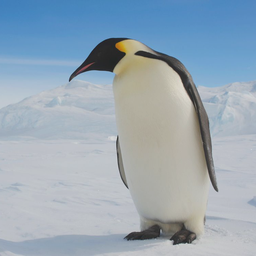

In [ ]:
x = preprocess(download_image('https://assets.bwbx.io/images/users/iqjWHBFdfxIU/iKIWgaiJUtss/v2/1000x-1.jpg'))
display_markdown('Original image:')
display(T.ToPILImage(mode='RGB')(x[0]))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


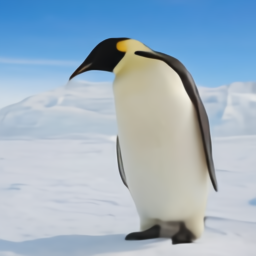

In [ ]:
import torch.nn.functional as F

z_logits = enc(x)
z = torch.argmax(z_logits, axis=1)
z = F.one_hot(z, num_classes=enc.vocab_size).permute(0, 3, 1, 2).float()

x_stats = dec(z).float()
x_rec = unmap_pixels(torch.sigmoid(x_stats[:, :3]))
x_rec = T.ToPILImage(mode='RGB')(x_rec[0])

# 음... 뭘 한거지?
display_markdown('Reconstructed image:')
display(x_rec)

# DALL-E(2)
* ref: https://github.com/ai-coodinator/DALL-E/blob/main/DALL_E.ipynb


In [ ]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-abead557-50c4-c4d5-d151-4c42692ec7a9)


In [ ]:
!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 -f https://download.pytorch.org/whl/torch_stable.html ftfy regex
!pip install DALL-E
!pip install ftfy
!git clone https://github.com/openai/CLIP.git
%cd /content/CLIP/

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████████▏        | 531.4 MB 1.4 MB/s eta 0:02:25ERROR: Exception:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/urllib3/response.py", line 438, in _error_catcher
    yield
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/urllib3/response.py", line 519, in read
    data = self._fp.read(amt) if not fp_closed else b""
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/cachecontrol/filewrapper.py", line 62, in read
    data = self.__fp.read(amt)
  File "/usr/lib/python3.7/http/client.py", line 465, in read
    n = self.readinto(b)
  File "/usr/lib/python3.7/http/client.py", line 509, in readinto
    n = self.fp.readinto(b)
  File "/usr/lib/python3.7/socket.py", line 589, in readinto
    return self._sock.recv_into(b)
  File "/usr/lib/python3.7/ssl.py", line 1071, in recv_into
    return self.read(nbytes, buffer)
  File "/usr/lib/python3

## 1. Preparing

In [ ]:
import torch
import numpy as np
import torchvision
import torchvision.transforms.functional as TF
import PIL
import matplotlib.pyplot as plt
import os
import random
import imageio
from IPython import display
from IPython.core.interactiveshell import InteractiveShell
import glob
from google.colab import output
InteractiveShell.ast_node_interactivity = "all"

# probably don't mess with this unless you're changing generator size
im_shape = [512, 512, 3]
sideX, sideY, channels = im_shape

def displ(img, pre_scaled=True):
  img = np.array(img)[:,:,:]
  img = np.transpose(img, (1, 2, 0))
  if not pre_scaled:
    img = scale(img, 48*4, 32*4)
  imageio.imwrite(str(3) + '.png', np.array(img))
  return display.Image(str(3)+'.png')

def gallery(array, ncols=2):
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    # want result.shape = (height*nrows, width*ncols, intensity)
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result

def card_padded(im, to_pad=3):
  return np.pad(np.pad(np.pad(im, [[1,1], [1,1], [0,0]],constant_values=0), [[2,2], [2,2], [0,0]],constant_values=1),
            [[to_pad,to_pad], [to_pad,to_pad], [0,0]],constant_values=0)

def get_all(img):
  img = np.transpose(img, (0,2,3,1))
  cards = np.zeros((img.shape[0], sideX+12, sideY+12, 3))
  for i in range(len(img)):
    cards[i] = card_padded(img[i])
  print(img.shape)
  cards = gallery(cards)
  imageio.imwrite(str(3) + '.png', np.array(cards))
  return display.Image(str(3)+'.png')

## 2. Perceptor

In [ ]:
import clip
clip.available_models()

# Load the model
perceptor, preprocess = clip.load('ViT-B/32', jit=True)
perceptor = perceptor.eval()

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'ViT-B/32', 'ViT-B/16']

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 122MiB/s]


## 3. Generator

In [ ]:
import io
import os, sys
import requests
import PIL
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from dall_e import map_pixels, unmap_pixels, load_model

target_image_size = sideX

def preprocess(img):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return map_pixels(img)

model = load_model("https://cdn.openai.com/dall-e/decoder.pkl", 'cuda')

## 4. Text input

In [ ]:
#text_input = "A beautiful woman swimming in the blue sea" 
text_input = "A cute rabbit next to the tall man."
tau_value =1.2

## 5. Latent coordinate

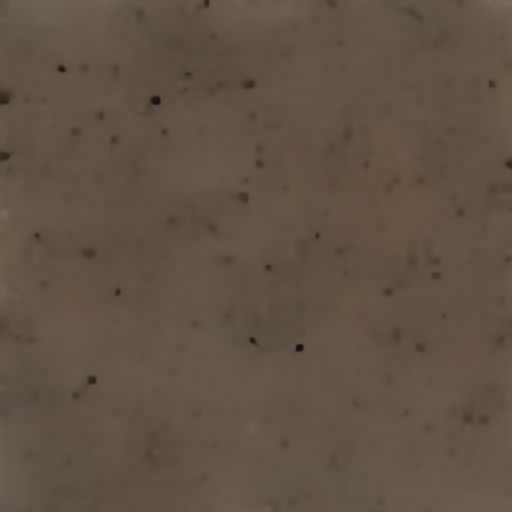

In [ ]:
class Pars(torch.nn.Module):
    def __init__(self):
        super(Pars, self).__init__()
        self.normu = torch.nn.Parameter(torch.randn(1, 8192, 64, 64).cuda())

    def forward(self):
      # normu = torch.nn.functional.gumbel_softmax(self.normu.view(1, 8192, -1), dim=-1).view(1, 8192, 64, 64)
      normu = torch.nn.functional.gumbel_softmax(self.normu.view(1, 8192, -1), dim=-1, tau=tau_value).view(1, 8192, 64, 64)
      return normu

lats = Pars().cuda()
mapper = [lats.normu]
optimizer = torch.optim.Adam([{'params': mapper, 'lr': .1}])
eps = 0
tx = clip.tokenize(text_input)
t = perceptor.encode_text(tx.cuda()).detach().clone()
nom = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

with torch.no_grad():
  mult = 1
  al = unmap_pixels(torch.sigmoid(model(lats()).cpu().float())).numpy()
  for allls in al:
    displ(allls[:3])
    print('\n')
  # print(torch.topk(lats().view(1, 8192, -1), k=3, dim=-1))

## 6. Train

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


##########################################################  [0, tensor([-2.0391], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 0


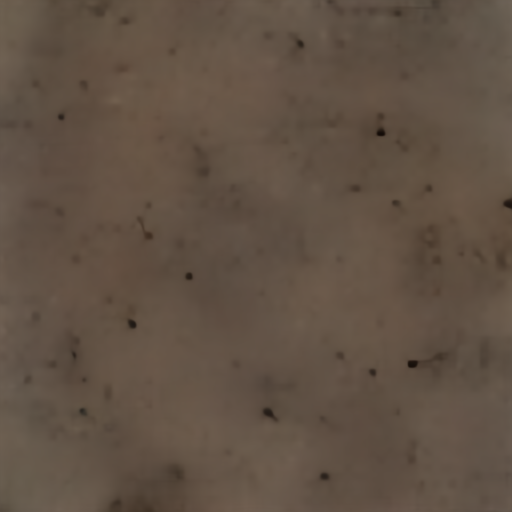



##########################################################  [0, tensor([-4.1484], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 100


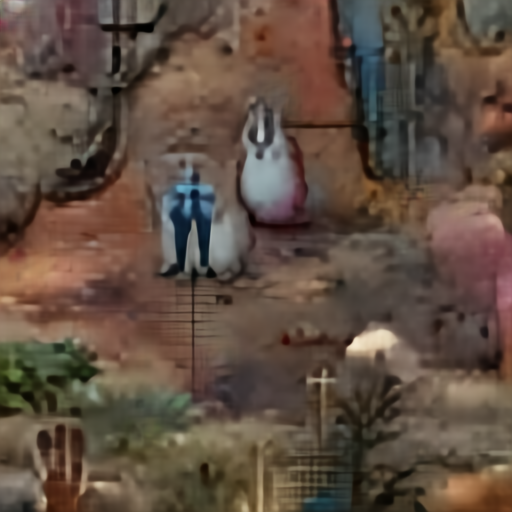



##########################################################  [0, tensor([-4.4883], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 200


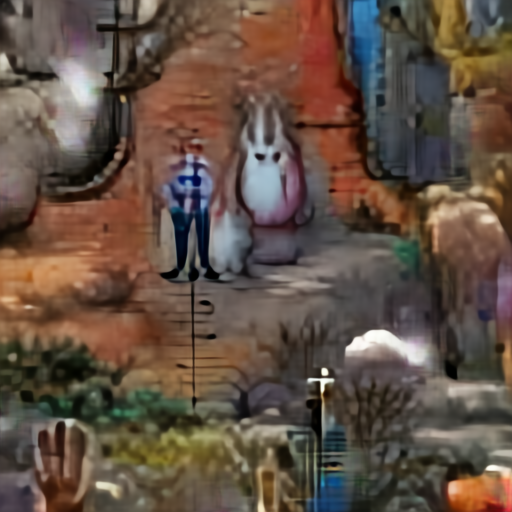



##########################################################  [0, tensor([-4.4062], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 300


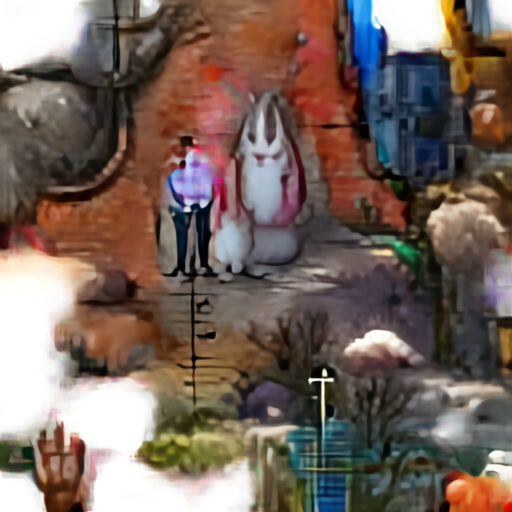



##########################################################  [0, tensor([-4.6445], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 400


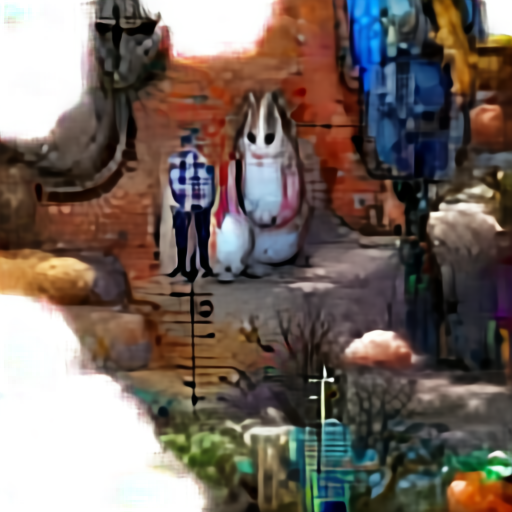



##########################################################  [0, tensor([-4.6406], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 500


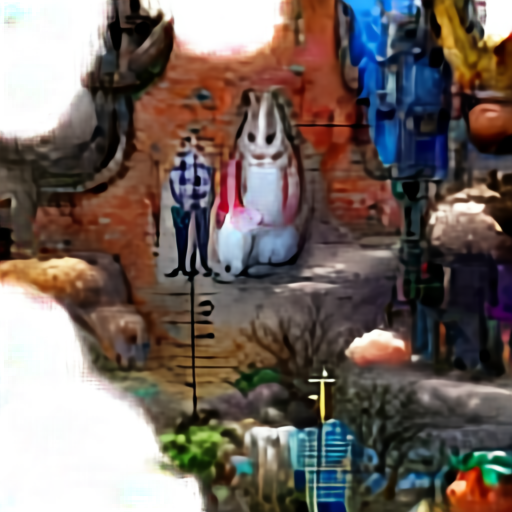



##########################################################  [0, tensor([-4.8750], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 600


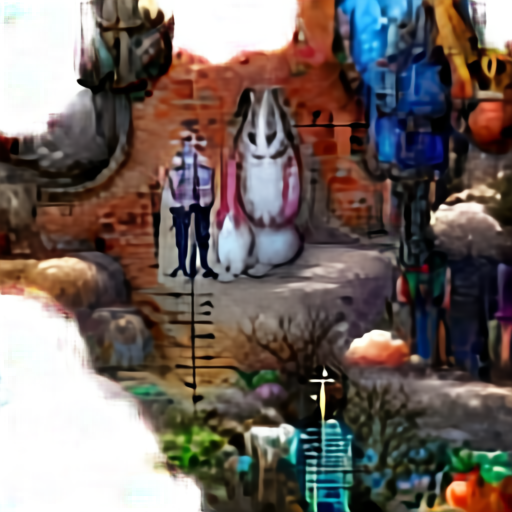



##########################################################  [0, tensor([-4.8984], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 700


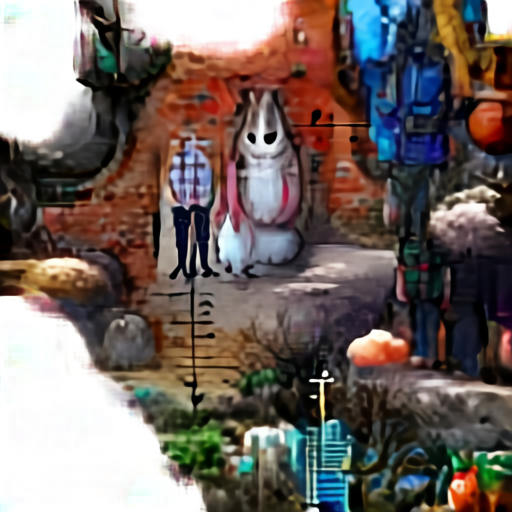



##########################################################  [0, tensor([-4.9375], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 800


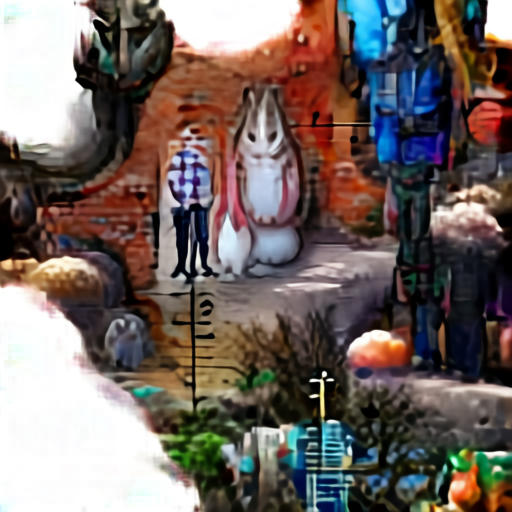



##########################################################  [0, tensor([-5.0781], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 900


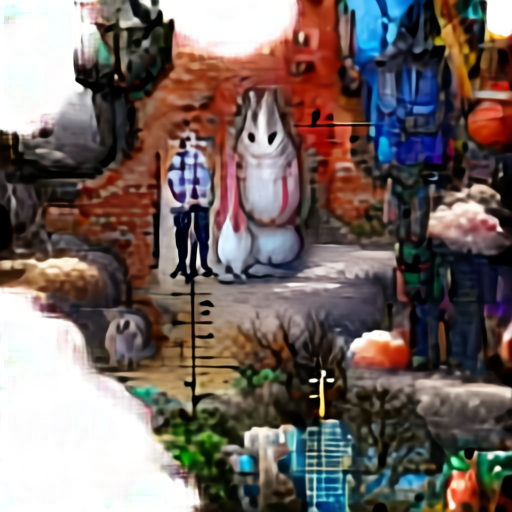



##########################################################  [0, tensor([-5.1016], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 1000


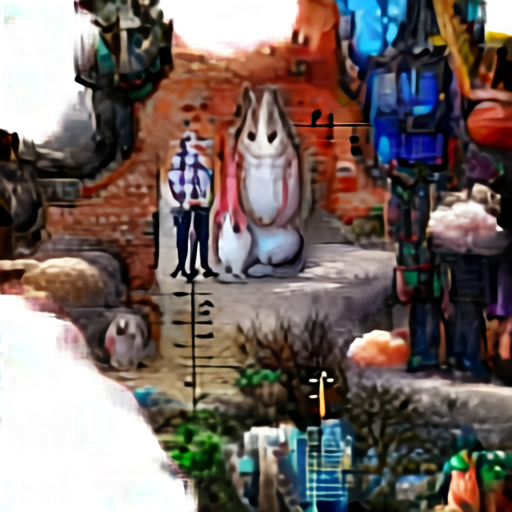

In [ ]:
def checkin(loss):
  print('''########################################################## ''',loss, '\n',itt)
  
  with torch.no_grad():
    al = unmap_pixels(torch.sigmoid(model(lats())[:, :3]).cpu().float()).numpy()
  for allls in al:
    displ(allls)
    display.display(display.Image(str(3)+'.png'))
    print('\n')
  # the people spoke and they love "ding"
  # output.eval_js('new Audio("https://freesound.org/data/previews/80/80921_1022651-lq.ogg").play()')

def ascend_txt():
  out = unmap_pixels(torch.sigmoid(model(lats())[:, :3].float()))
  cutn = 64 # improves quality
  p_s = []
  for ch in range(cutn):
    size = int(sideX*torch.zeros(1,).normal_(mean=.8, std=.3).clip(.5, .98))
    offsetx = torch.randint(0, sideX - size, ())
    offsety = torch.randint(0, sideX - size, ())
    apper = out[:, :, offsetx:offsetx + size, offsety:offsety + size]
    apper = torch.nn.functional.interpolate(apper, (224,224), mode='bilinear')
    p_s.append(apper)
  into = torch.cat(p_s, 0)
  # into = torch.nn.functional.interpolate(out, (224,224), mode='nearest')
  into = nom(into)
  iii = perceptor.encode_image(into)
  llls = lats()
  lat_l = 0
  return [lat_l, 10*-torch.cosine_similarity(t, iii).view(-1, 1).T.mean(1)]

def train(i):
  loss1 = ascend_txt()
  loss = loss1[0] + loss1[1]
  loss = loss.mean()
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
    
  if itt % 100 == 0:
    checkin(loss1)
    shutil.copy('./3.png', './images/%s.png'%str(int(itt/100)).zfill(6))

import shutil

if os.path.isdir('images'):
    shutil.rmtree('images')
os.makedirs('images', exist_ok=True)

itt = 0
for asatreat in range(1100):
  train(itt)
  itt+=1

## 7. Make movie

In [ ]:
if os.path.exists('./output2.mp4'):
   os.remove('./output2.mp4')

!ffmpeg -r 2 -i images/%06d.png -vcodec libx264 -pix_fmt yuv420p output2.mp4

# DALL-E(3)
* github: https://github.com/lucidrains/big-sleep
* colab: https://colab.research.google.com/drive/1NCceX2mbiKOSlAd_o7IU7nA9UskKN5WR?usp=sharing#scrollTo=etzxXVZ_r-Nf

# Reference
* Text2Image: https://github.com/topics/text-to-image
* DALL-E: https://daddyprogrammer.org/tech-news/?order_by=fn_user_name&order_type=asc&vid=465
* StackGAN: https://github.com/hanzhanggit/